In [11]:
import kagglehub
import os
import pandas as pd

# 1. Download e Carregamento (O seu código original estava ótimo aqui)
path = kagglehub.dataset_download("hrishitpatil/flight-data-2024")
arquivos = os.listdir(path)
nome_arquivo_csv = [f for f in arquivos if f.endswith('.csv')][0]
caminho_completo = os.path.join(path, nome_arquivo_csv)
df = pd.read_csv(caminho_completo)

# 2. DIAGNÓSTICO (Isso é o mais importante agora)
print("--- NOMES DAS COLUNAS ---")
print(df.columns.tolist())
print("\n--- AMOSTRA DOS DADOS ---")
display(df.head(3))

Using Colab cache for faster access to the 'flight-data-2024' dataset.
--- NOMES DAS COLUNAS ---
['year', 'month', 'day_of_month', 'day_of_week', 'fl_date', 'op_unique_carrier', 'op_carrier_fl_num', 'origin', 'origin_city_name', 'origin_state_nm', 'dest', 'dest_city_name', 'dest_state_nm', 'crs_dep_time', 'dep_time', 'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled', 'cancellation_code', 'diverted', 'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'distance', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']

--- AMOSTRA DOS DADOS ---


,year,month,day_of_month,day_of_week,fl_date,op_unique_carrier,op_carrier_fl_num,origin,origin_city_name,origin_state_nm,...,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2024,4,18,4,2024-04-18,MQ,3535.0,DFW,"Dallas/Fort Worth, TX",Texas,...,0,151.0,144.0,119.0,835.0,0,0,0,0,0
1,2024,1,1,1,2024-01-01,AA,148.0,CLT,"Charlotte, NC",North Carolina,...,0,286.0,273.0,253.0,1773.0,0,0,0,0,0
2,2024,12,12,4,2024-12-12,9E,5440.0,CHA,"Chattanooga, TN",Tennessee,...,0,59.0,50.0,29.0,106.0,0,0,0,0,0


--- VERIFICAÇÃO DE COLUNAS ---
Colunas encontradas: ['year', 'month', 'day_of_month', 'day_of_week', 'fl_date', 'op_unique_carrier', 'op_carrier_fl_num', 'origin', 'origin_city_name', 'origin_state_nm'] ...
SUCESSO: Coluna 'atraso_bin' criada com base em 'dep_delay'.


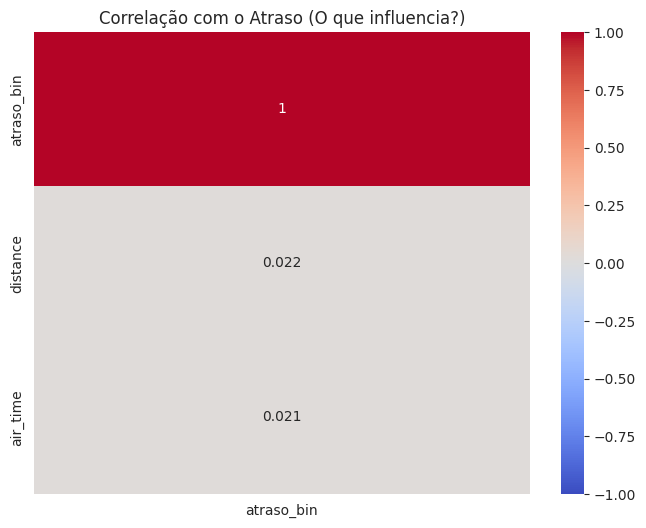

/tmp/ipython-input-628287656.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=media_atrasos.index, y=media_atrasos.values, palette='viridis')


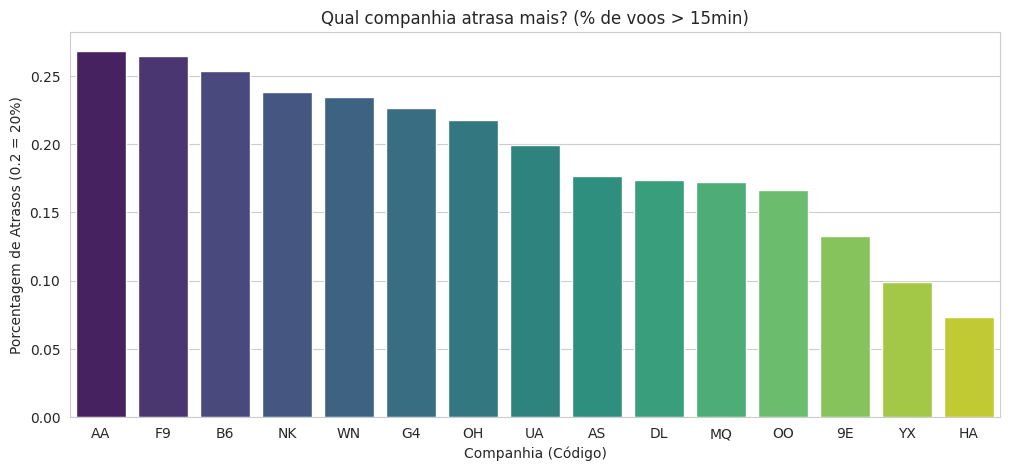

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- 1. LIMPEZA E TRADUÇÃO (Com os nomes REAIS do dataset hrishitpatil) ---

# Fazendo uma cópia para não mexer no original
df_limpo = df.copy()

# Mapeamento para os nomes que provavelmente estão no seu CSV
# Baseado no padrão do dataset "Flight Delay Dataset - 2024" do Kaggle
coluna_atraso_minutos = 'dep_delay'       # Atraso na partida em minutos
coluna_data = 'flight_date'               # Data do voo
coluna_companhia = 'op_unique_carrier'    # Código da companhia (ex: AA, DL)
coluna_distancia = 'distance'             # Distância (se existir)

print("--- VERIFICAÇÃO DE COLUNAS ---")
print(f"Colunas encontradas: {df_limpo.columns.tolist()[:10]} ...") # Mostra as 10 primeiras

# --- 2. ENGENHARIA DE FEATURES ---

# A. Criar o Alvo Binário (Target)
# Regra: Se atrasou >= 15 minutos, é 1 (Atrasado). Se não, 0.
# fillna(0) é importante porque voos sem registro de atraso geralmente saíram na hora.
if coluna_atraso_minutos in df_limpo.columns:
    df_limpo['atraso_bin'] = df_limpo[coluna_atraso_minutos].fillna(0).apply(lambda x: 1 if x >= 15 else 0)
    print(f"SUCESSO: Coluna 'atraso_bin' criada com base em '{coluna_atraso_minutos}'.")
else:
    print(f"ERRO CRÍTICO: Não achei a coluna '{coluna_atraso_minutos}'. Verifique os nomes acima.")

# B. Tratar Datas e Horas
try:
    if coluna_data in df_limpo.columns:
        df_limpo['data_formatada'] = pd.to_datetime(df_limpo[coluna_data])
        df_limpo['dia_semana'] = df_limpo['data_formatada'].dt.day_name()
        print("SUCESSO: Datas processadas.")

        # Tenta extrair a hora se houver uma coluna de horário (dep_time costuma ser HHMM, ex: 1430)
        if 'dep_time' in df_limpo.columns:
            # Tratamento chato: converter 1430 (float/int) para 14 (hora)
            df_limpo['hora'] = df_limpo['dep_time'].fillna(0).astype(int).astype(str).str.zfill(4).str[:2].astype(int)
            # Filtra horas inválidas (>24) que as vezes aparecem
            df_limpo.loc[df_limpo['hora'] > 23, 'hora'] = 0
            print("SUCESSO: Hora extraída da coluna 'dep_time'.")
        else:
            print("AVISO: Coluna 'dep_time' não encontrada. Análise por horário ficará vazia.")

except Exception as e:
    print(f"Erro ao processar datas: {e}")

# --- 3. ANÁLISE MULTIVARIADA (Gráficos) ---

sns.set_style("whitegrid")

# GRÁFICO 1: Correlação Numérica (Focado no Atraso)
plt.figure(figsize=(8, 6))
# Seleciona apenas colunas numéricas relevantes para não poluir
cols_interesse = ['atraso_bin', 'distance', 'air_time', 'hora'] # Adicionei 'air_time' que costuma ter
cols_existentes = [c for c in cols_interesse if c in df_limpo.columns]

if len(cols_existentes) > 1:
    correlacao = df_limpo[cols_existentes].corr()
    sns.heatmap(correlacao[['atraso_bin']].sort_values(by='atraso_bin', ascending=False),
                annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Correlação com o Atraso (O que influencia?)")
    plt.show()
else:
    print("Não há colunas numéricas suficientes para correlação.")

# GRÁFICO 2: Taxa de Atraso por Companhia
if coluna_companhia in df_limpo.columns and 'atraso_bin' in df_limpo.columns:
    plt.figure(figsize=(12, 5))
    # Calcula a média
    media_atrasos = df_limpo.groupby(coluna_companhia)['atraso_bin'].mean().sort_values(ascending=False)

    sns.barplot(x=media_atrasos.index, y=media_atrasos.values, palette='viridis')
    plt.title("Qual companhia atrasa mais? (% de voos > 15min)")
    plt.ylabel("Porcentagem de Atrasos (0.2 = 20%)")
    plt.xlabel("Companhia (Código)")
    plt.show()

# GRÁFICO 3: Taxa de Atraso por Hora do Dia (O 'Efeito Bola de Neve')
if 'hora' in df_limpo.columns and 'atraso_bin' in df_limpo.columns:
    plt.figure(figsize=(12, 5))
    media_hora = df_limpo.groupby('hora')['atraso_bin'].mean()
    sns.lineplot(x=media_hora.index, y=media_hora.values, marker="o", color="red")
    plt.title("Efeito Bola de Neve: O atraso aumenta ao longo do dia?")
    plt.ylabel("% de Atrasos")
    plt.xlabel("Hora do Dia (0-23h)")
    plt.xticks(range(0, 24))
    plt.grid(True)
    plt.show()

Sucesso! Vamos usar a coluna 'crs_dep_time' para análise de horários.


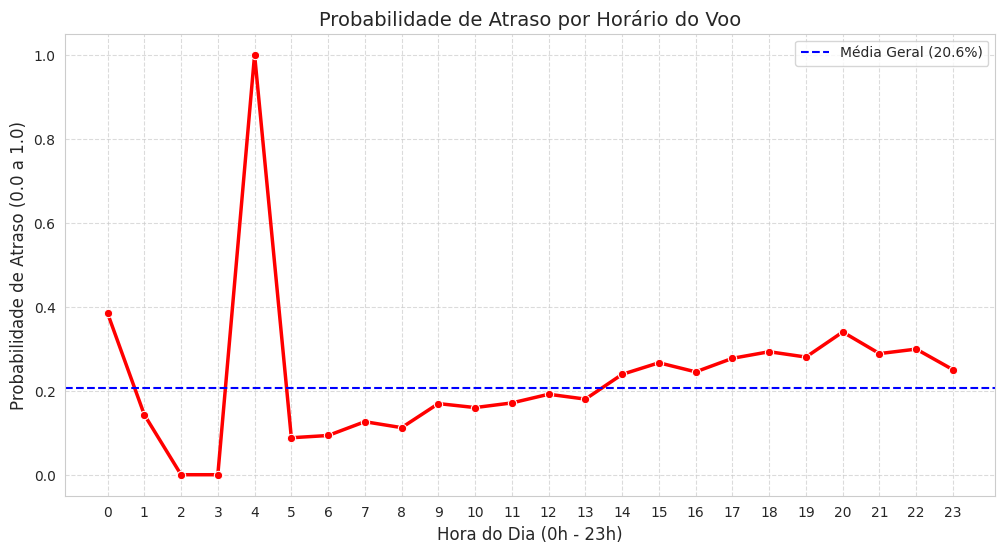


INTERPRETAÇÃO SUGERIDA:
Se a linha vermelha sobe conforme as horas passam, confirmamos o 'Efeito Bola de Neve'.
Voos no final do dia acumulam atrasos dos voos anteriores.


In [15]:
# --- CORREÇÃO PARA O GRÁFICO 3 (ANÁLISE TEMPORAL) ---
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Tenta identificar qual é a coluna de hora (Agendada ou Real)
# Lista de candidatos comuns nesse tipo de dataset
candidatos_hora = ['crs_dep_time', 'dep_time', 'sched_dep_time', 'std']

coluna_hora_encontrada = None
for col in candidatos_hora:
    if col in df_limpo.columns:
        coluna_hora_encontrada = col
        print(f"Sucesso! Vamos usar a coluna '{col}' para análise de horários.")
        break

if coluna_hora_encontrada:
    # 2. Tratamento da Hora (Extrair apenas a hora cheia: 1430 -> 14)
    # Converte para string, preenche com zeros à esquerda (ex: 530 vira 0530) e pega os 2 primeiros dígitos
    try:
        df_limpo['hora_final'] = df_limpo[coluna_hora_encontrada].fillna(0).astype(int).astype(str).str.zfill(4).str[:2].astype(int)

        # Filtra erros (horas maiores que 23)
        df_limpo = df_limpo[df_limpo['hora_final'] <= 23]

        # 3. Gerar o Gráfico
        plt.figure(figsize=(12, 6))

        # Agrupa por hora e calcula a taxa de atraso
        media_hora = df_limpo.groupby('hora_final')['atraso_bin'].mean()

        # Plot
        sns.lineplot(x=media_hora.index, y=media_hora.values, marker="o", color="red", linewidth=2.5)

        # Estética
        plt.title("Probabilidade de Atraso por Horário do Voo", fontsize=14)
        plt.ylabel("Probabilidade de Atraso (0.0 a 1.0)", fontsize=12)
        plt.xlabel("Hora do Dia (0h - 23h)", fontsize=12)
        plt.xticks(range(0, 24)) # Mostra todas as horas no eixo X
        plt.grid(True, linestyle='--', alpha=0.7)

        # Adiciona uma linha de média geral para comparação
        media_geral = df_limpo['atraso_bin'].mean()
        plt.axhline(media_geral, color='blue', linestyle='--', label=f'Média Geral ({media_geral:.1%})')
        plt.legend()

        plt.show()

        print("\nINTERPRETAÇÃO SUGERIDA:")
        print("Se a linha vermelha sobe conforme as horas passam, confirmamos o 'Efeito Bola de Neve'.")
        print("Voos no final do dia acumulam atrasos dos voos anteriores.")

    except Exception as e:
        print(f"Erro ao processar a hora: {e}")
else:
    print("ERRO: Ainda não encontrei a coluna de hora.")
    print("Por favor, cole aqui o resultado de: print(df.columns.tolist())")

            % Atraso  Qtd Voos
hora_final                    
0           0.384615        13
1           0.142857         7
2           0.000000         2
3           0.000000         3
4           1.000000         1
5           0.088028       284
6           0.093391       696
7           0.126255       697
8           0.112094       678
9           0.169369       555
10          0.159875       638
11          0.170984       579
12          0.191589       642
13          0.180033       611
14          0.239016       569
15          0.266553       589
16          0.244932       592
17          0.277165       635
18          0.292835       642
19          0.280148       539
20          0.339853       409
21          0.288401       319
22          0.299107       224
23          0.250000        76


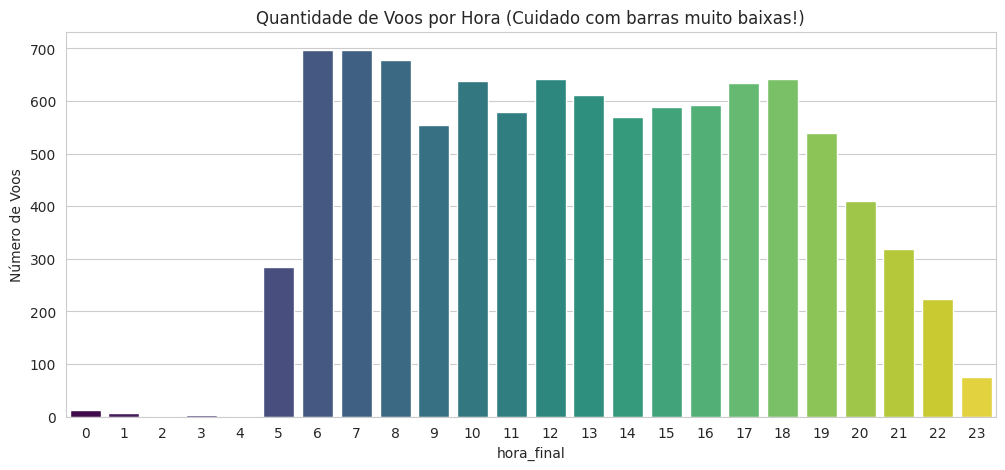

In [18]:
# Verificando se o pico das 04h é real ou falta de dados
contagem_hora = df_limpo.groupby('hora_final')['atraso_bin'].agg(['mean', 'count'])
contagem_hora.columns = ['% Atraso', 'Qtd Voos']

# Ordena pelo horário para você ler de 0 a 23
print(contagem_hora.sort_index())

# Plota as barras de quantidade para comparar visualmente
plt.figure(figsize=(12, 5))
sns.barplot(x=contagem_hora.index, y='Qtd Voos', data=contagem_hora, palette='viridis', hue=contagem_hora.index, legend=False)
plt.title("Quantidade de Voos por Hora (Cuidado com barras muito baixas!)")
plt.ylabel("Número de Voos")
plt.show()

In [19]:
# --- ENTREGÁVEL EXTRA: TABELAS DE TAXAS DE ATRASO ---

# Função para formatar e exibir tabelas bonitas
def mostrar_taxa_atraso(df, coluna, nome_coluna):
    tabela = df.groupby(coluna)['atraso_bin'].agg(['count', 'mean', 'sum'])
    tabela.columns = ['Total de Voos', 'Taxa de Atraso (%)', 'Qtd Atrasos']

    # Formatação
    tabela['Taxa de Atraso (%)'] = (tabela['Taxa de Atraso (%)'] * 100).round(2)
    tabela = tabela.sort_values(by='Taxa de Atraso (%)', ascending=False)

    print(f"\n--- Tabela de Atraso por: {nome_coluna} ---")
    display(tabela)

# 1. Tabela por Companhia Aérea
if 'op_unique_carrier' in df_limpo.columns:
    mostrar_taxa_atraso(df_limpo, 'op_unique_carrier', 'Companhia Aérea')

# 2. Tabela por Dia da Semana (Para validar sazonalidade)
if 'dia_semana' in df_limpo.columns:
    # Ordenar dias da semana corretamente seria ideal, mas pelo valor já serve
    mostrar_taxa_atraso(df_limpo, 'dia_semana', 'Dia da Semana')

# 3. Tabela por Turno (Aquela ideia nossa de agrupar horários)
# Vamos criar o turno rapidinho só para essa tabela
if 'hora_final' in df_limpo.columns:
    # 0-11 = Manhã (Turno 1), 12-23 = Tarde/Noite (Turno 2)
    df_limpo['turno'] = df_limpo['hora_final'].apply(lambda x: '1. Manhã (00-11h)' if x < 12 else '2. Tarde/Noite (12-23h)')
    mostrar_taxa_atraso(df_limpo, 'turno', 'Turno do Dia')


--- Tabela de Atraso por: Companhia Aérea ---


,Total de Voos,Taxa de Atraso (%),Qtd Atrasos
op_unique_carrier,,,
AA,1385,26.86,372
F9,295,26.44,78
B6,331,25.38,84
NK,361,23.82,86
WN,2022,23.49,475
G4,172,22.67,39
OH,326,21.78,71
UA,1033,19.94,206
AS,323,17.65,57



--- Tabela de Atraso por: Turno do Dia ---


,Total de Voos,Taxa de Atraso (%),Qtd Atrasos
turno,,,
2. Tarde/Noite (12-23h),5847,25.71,1503
1. Manhã (00-11h),4153,13.39,556
